## Data Generator 
Created: February 18, 2020

This series of notebooks generate synthetic data for different components of the food supply chain. It models activities like restaurant orders using normal distributions with parameters number of events $n$, mean $\mu$, and standard deviation $\sigma$.  After the distribution or distributions are is created, a function samples the distribution and generates $n$ events for a specific type of event: telemetry event, event enrichment, or session enrichment event. The events are written to a text file and exported locally. 

This notebook specifically allows a user to specify any number of parameters (3 for normal distribution) for any number of distributions using a textfile. This generates events that are saved and plots a histogram of those events. 

The outputs of the events follows the data model described in this document: https://zumepizza.atlassian.net/wiki/spaces/TERA/pages/615318459/Data+Model

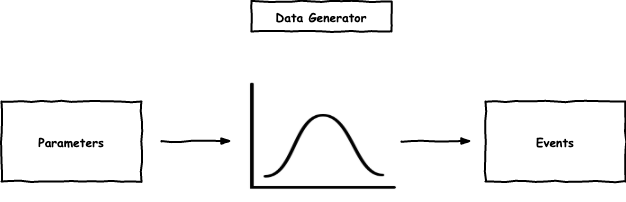

In [1]:
from IPython.display import Image
Image(filename="/Users/newtonkwan/Documents/zume/data-generator/data_generator_pipeline.png")

### Version 1 (2/6/20)
- Shows how to create a normal distribution
- Outputs three text files, each with one of example of the following: telemetry event, enriched event, and enriched session. 

### Version 2 (2/10/20)
- Same as version 1 including the following
- Write three functions that allow a user to specify the number of events to simulate for each of the three kinds of events. The outputs are three text files, each with n number of events of the following kind: telemetry event, enriched event, and enriched session. 

### Version 3 (2/10/20)
- Same as version 2 including the following
- Written a function that generates synthetic data for tomato harvests by month that follows a normal distribution whose parameters can be user specified. 
- The event enrichment events generator can generate 100,000 events every 5 seconds and write those events in about 5 seconds for a total of 10 seconds per 100,000 events. 

### Version 4 (2/12/20)
- Same as version 3 including the following
- Written a function that generates synthetic data for Tito's Tacos that has two normal distributions to describe lunch and dinner orders using 6 user specfied parameters (number of lunch orders, number of dinner orders, lunch mean, dinner mean, lunch standard deviation, and dinner standard deviation) to generate data. 
- Added details Part C to telemetry events for orders because I did not consider order details to be event enrichment.
- Plotted a denormlaized normal distribution (amplitude * pdf) rather than normalizing the histogram and fitting it to a pdf because it is more intuitive to view orders of the y-axis than a probability density for number of orders 

### Version 5 (2/12/20)
- Same as version 4 including the following
- Wrote a function that can take in an arbitrary number of sets of parameters (say lunch and dinner or breakfast, lunch, dinner, and dessert).
- Instead of hardcoding in the parameters, a user can specify the parameters in a textfile 
- The readability of the code has been greatly improved by abstracting out the event generating part into its own function, which allows for n number of sets of parameters. 

### Version 6 (2/13/20)
- Same as version 5 including the following
- Explicitly wrote assumptions for the data being generated, including each event being a unique consumer, each event being a unique session, and each event being only one business customer. 
- Added a simple diagram explaining the data generator. 

### Version 7 (2/18/20)
- Same as version 6 including the following
- Changed the timestamps to be specified by a date range, not just the current time. 

### Version 8 (2/19/20)
- Same as version 7 including the following
- Allowed for the exporting to csv file  

### Version 9 (2/20/20)
- Same as version 8 including the following
- refactored the sample_distributions function to make the class cleaner and easier to mod

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas
from scipy import stats
import json
from datetime import datetime,timezone,timedelta
from dateutil import tz
import uuid
import random
import time
import csv
import os
%config InlineBackend.figure_format = 'retina'

Parameters for restaurant 1 
number of orders, mu, sigma
200, 12.5, 1
250, 18.5, 1.2

Parameters for restaurant 2 
number of orders, mu, sigma
180, 12.0, 1.0
275, 18.5, 1.1

Parameters for restaurant 3
number of orders, mu, sigma
210, 12.2, 0.9
290, 19.0, 1.0



I wrote a function that takes in a textfile of parameters that allows for an arbitrary number of sets of parameters to include in the order distribution. Up to 4 distinct colors, but will default to other colors in the case where there are more than 4 sets of parameters. I also rewrote a function that allows the for arbitrary number of paramters inside of the event generator. 

In [2]:
def write_to_file(events, filename):
    '''
    Converts a list of dictionaries into json events saved as a text file as filename
    Input: Events is a list of events dictionaries and filename is a string
    Output: Print number of events written and filename 
    '''
    n = len(events)
    with open(filename, 'w') as file_json: 
        json.dump(events, file_json)
    
    print("Successfully created the file", filename, "with", n, "events")
    return 

In [72]:
def sample_distributions(num_of_orders, mu, sigma):
    '''
    This function takes three parameters, creates a distribution, and samples that 
    distribution to create a list of events. 
    Ex: [100, 6, 1]
    The function would create a normal distribution with n = 100, mean = 6, and 
    standard deviation = 1, sample the distribution 100 times, creating 100 events 
    in the format of the data model. It will return a list of these events 
    
    Input: number of orders, the mean mu, and the standard deviation sigma 
    Output: returns n events in a list 
    '''
    events = [] 
    samples = []
    
    # assumptions
    # customer is the same for all events 
    customer = "Titos Tacos"       
    
    # the hub is always the same 
    hub_id = str(uuid.uuid1())   
    
    base = datetime(2019, 12, 31)
    numdays = 1
    dateList = []
    for x in range (0, numdays):
        dateList.append(base - timedelta(days = x))
    
    # the session is always unique per event  
    
    for curr_date in dateList:
        for i in range(num_of_orders):
            event_dict = {} 
            
            # setting up variables
            from_zone = tz.tzutc()
            to_zone = tz.tzlocal()
            utc = datetime.utcnow() 
            utc = utc.replace(tzinfo=from_zone)
            #local = utc.astimezone(to_zone)
            
            # part A telemetry event
            correlation_id = str(uuid.uuid1())   # will always be unique for each event 
            customer = "Titos Tacos"             # business customer the row was generated for
            type_of_data = "event"              
            version = "1.0.0"
            source = "telemetry"
            UTCtimestamp = str(utc)              # UTC of time the event was generated 
    
            # part B telemetry details
            event_type = "customer_order"
            customer_id = str(uuid.uuid1())      # ID of a specific customer 
            session_id = str(uuid.uuid1())
            hub_id = hub_id                      # unique to the restaurant location
            hub_location = None                  # None if it's stationary
            menu_version =  "1.0.0"
            experiments = None    
            

            hour_decimal = round(np.random.normal(mu, sigma, 1)[0], 2)
            #print(hour_decimal)
            hour_floor = int(np.floor(hour_decimal))
            minute_decimal = (hour_decimal - hour_floor) * 60 
            minute_floor = int(np.floor(minute_decimal))
            second_decimal = (minute_decimal - minute_floor) * 60
            second_floor = int(np.floor(second_decimal))
            
            curr_date = curr_date.replace(hour=hour_floor, minute=minute_floor, second=second_floor, tzinfo = tz.tzlocal())
            localtime = str(curr_date)               # local time of the event at the restaurant 
            UTCeventtime = str(curr_date.astimezone(tz.tzutc()))                                #  UTC of the event at the restaurant 
    
            # part C telemetry details 
            order_snapshot = []
            number_of_skus = random.randint(1,2) # generate 1 or 2 
            if number_of_skus == 1: 
                total = 6.0 
            else: 
                total = 15.50 
            for sku_num in range(number_of_skus):
                if sku_num == 0: 
                    subtotal_sample = 6.0 
                else: 
                    subtotal_sample = 9.50
                d = {"sku": sku_num+1, 
                     "amount": 1,
                     "subtotal": subtotal_sample,
                     "total": total
                     #,"hour of the day": hour_decimal
                     }
                order_snapshot.append(d)
                
            samples.append(hour_decimal)
        
            
            # part C telemetry details
            partC_event_details_dict = {"order_snapshot": order_snapshot
                                                  }
            
            # part B telemetry details
            partB_event_details_dict = {"event_type": event_type,           # Every event (part A type) has a event type in part B
                                        "customer_id": customer_id,         # The ID for a specific customer. This is null if a customer is not logged in or we cannot find it 
                                        "session_id": session_id,           # An ID that joins a set of events into a specific customer session. 
                                        "hub_id": hub_id,                   # The ID for the specific Hub (kiosk, etc.) that is being viewed
                                        "hub_location": hub_location,       # The location of the specific hub. For hub's in which the location does not every change, such as a fixed Kiosk, this field will be null as location can be obtained through a lookup
                                        "menu_version": menu_version,       # You can lookup details about this menu with this id.  
                                        "experiments": experiments,         # If a user is in an experiment, it would be represented here in the format experiment:treatment with pipe delimitation.  E.G. if the user was in treatment 2 of a ux experiment titled redbuttons, and treatment 12 of an experiment titled aggressivemarketing, the field would be "redbuttons:2|aggressivemarketing:12
                                        "localtime": localtime,             # The local time this event was generated
                                        "UTCtime": UTCeventtime,            # The utc time this event was generated
                                        "details": partC_event_details_dict
                                       }
            
            # part A 
            event_dict = {"correlation_id": correlation_id,    # The is the id associated with all telemetry events 
                          "customer": customer,
                          "type": type_of_data,                # The type of data. Typically "event", which is something generated off of a specific event
                          "version": version,                  # The version of this data
                          "source": source,                    # Where the data was generated. Often "telemetry", but can be "enrichment".
                          "UTCtimestamp": UTCtimestamp,        # A timestamp for when this specific row of data was created 
                          "details": partB_event_details_dict  # Details is where part B data and part C data is stored.   
                                       }
            events.append(event_dict)
    return events, samples

In [4]:
def generate_orders_by_hour(parameters):
    '''
    This function generates events based on distributions parametrized by parameters 
    Input: parameters is list of lists of string parameters in the format [orders, mu, sigma]
    Output: a list of order_events and a list of lists of order samples
    '''
    
    order_events = [] 
    order_samples = [] 

    for p in parameters: 
        num_orders = p[0] 
        mu = p[1]
        sigma = p[2]
        events, samples = sample_distributions(num_orders, mu, sigma)
        order_events += events
        order_samples.append(samples) 
        
    return order_events, order_samples


Time to generate 500 events: 0.047 seconds


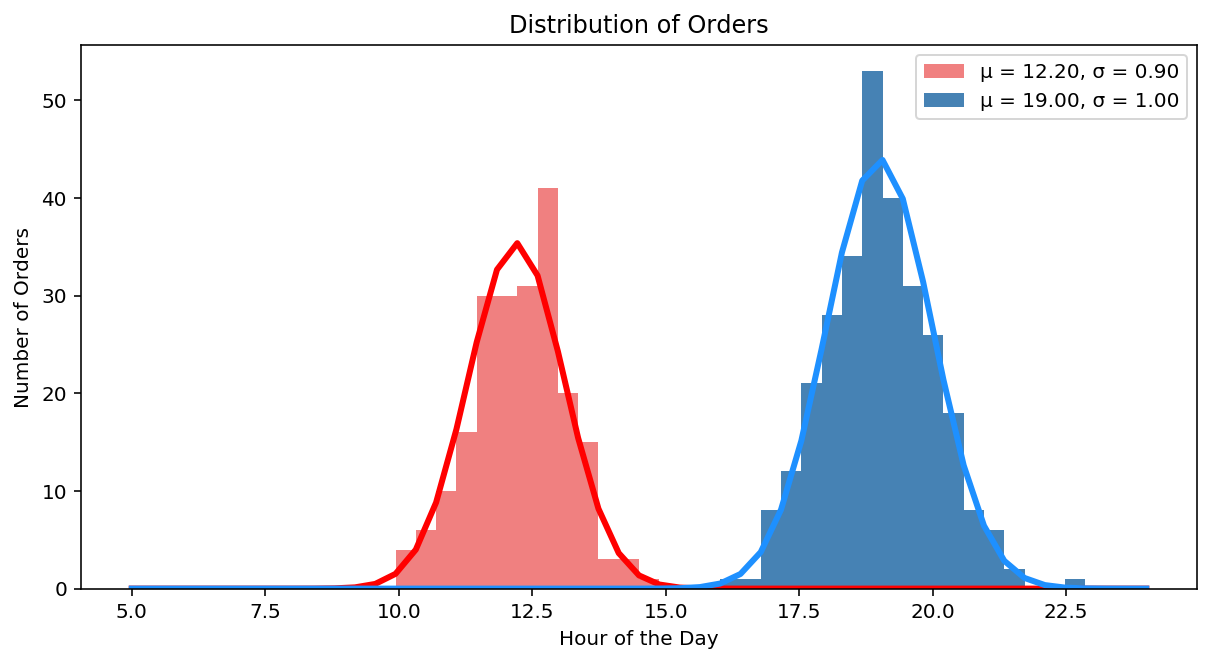

Successfully created the file notebook_v7_titos_tacos_order_events.txt with 500 events
Time to write json: 0.028790950775146484
[
    {
        "correlation_id": "9b103956-52c7-11ea-81d6-acde48001122",
        "customer": "Titos Tacos",
        "type": "event",
        "version": "1.0.0",
        "source": "telemetry",
        "UTCtimestamp": "2020-02-19 03:26:24.172265+00:00",
        "details": {
            "event_type": "customer_order",
            "customer_id": "9b1039f6-52c7-11ea-81d6-acde48001122",
            "session_id": "9b103a3c-52c7-11ea-81d6-acde48001122",
            "hub_id": "9b1037b2-52c7-11ea-81d6-acde48001122",
            "hub_location": null,
            "menu_version": "1.0.0",
            "experiments": null,
            "localtime": "2019-12-31 13:09:00-08:00",
            "UTCtime": "2019-12-31 21:09:00+00:00",
            "details": {
                "order_snapshot": [
                    {
                        "sku": 1,
                        "amount"

In [73]:
plt.figure(figsize=(10,5))
current_directory = os.getcwd()

with open(current_directory + "/" + "parameters.txt") as f: 
    raw = f.read().splitlines()[2:]

parameters = []
for p in raw: 
    nth_params = list(map(float, p.split(",")))
    nth_params[0] = int(nth_params[0])
    parameters.append(nth_params)
    
interval = (5, 24) # 6am to 11pm 
num_of_bins = 50
dx = (interval[1] - interval[0]) / num_of_bins # interval length / number of bins = bin_width


generate_time_start = time.time()
events, order_samples = generate_orders_by_hour(parameters)
generate_time_taken = time.time() - generate_time_start 

print("Time to generate", len(events), "events:", round(generate_time_taken, 3), "seconds")
colors = [["black", "wheat"], 
          ["slateblue", "indigo"], 
          ["steelblue", "dodgerblue"], 
          ["lightcoral", "red"]]

for samples, p in zip(order_samples, parameters): 
    number_of_orders = p[0]
    mu = p[1]
    sigma = p[2]
    amplitude = number_of_orders * dx # number of orders * width of a bin. used to scale 
    if colors != []:
        color = colors.pop()
    else: 
        color = ("darkorange", "yellowgreen")
    count, bins, ignored = plt.hist(samples, bins=num_of_bins, 
                                    range=interval, color = color[0], 
                                    label = "\u03BC = {:.2f}, \u03C3 = {:.2f}".format(mu, sigma))
    pdf = stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins,amplitude*pdf, linewidth=3, color=color[1])

plt.title("Distribution of Orders")
plt.ylabel("Number of Orders")
plt.xlabel("Hour of the Day")
plt.legend()
plt.show()

write_data_start = time.time()
save_directory = os.getcwd()
filename = "notebook_v7_titos_tacos_order_events.txt"
write_to_file(events, filename)
with open(save_directory + "/" + filename) as file:
    data = json.load(file)

write_data_end = time.time()
write_time_taken = write_data_end - write_data_start 
print("Time to write json:", write_time_taken)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

In [57]:
# Assumptions about the model in the form of functions 

# TO-DO
# 1. Capturing the assumptions made every time data is generated

# Order time assumptions 
# ----------------------
def sample_time_from_normal(mean, std):
    '''
    Assumption: the order time is distributed normally. 
    
    Given a mean and std, sample a value from a normal distribution 
    and convert that value into hour, day, and second. 
    '''
    
    hour_decimal = round(np.random.normal(mean, std, 1)[0], 2)
    hour_floor = int(np.floor(hour_decimal))
    minute_decimal = (hour_decimal - hour_floor) * 60 
    minute_floor = int(np.floor(minute_decimal))
    second_decimal = (minute_decimal - minute_floor) * 60
    second_floor = int(np.floor(second_decimal))
            
    return hour_floor, minute_floor, second_floor

# CSV row assumptions 
# -------------------
def single_csv_order(location, opened, amount, tax, total):
    ''' 
    Assumption: The order for a restaurant has location, opened, amount, tax, and total 
    Location = human readable string of location like 'Columbia Tower'
    Opened = string of the time an order was begun 
    Amount = amount of money before tax spent on order 
    Tax = amount of money paid in tax 
    Total = amount + tax 
    '''
    order = { 
              "Location": location, 
              "Opened": opened,
              "Amount": amount, 
              "Tax": tax, 
              "Total": total
            }  
    return order

# JSON event assumptions 
# ----------------------
def single_customer_order_json_telemetry_event(customer_name, hub_id, curr_date, hour, minute, second, amount, tax, total):
    '''
    Assumptions
    '''
    event_dict = {} 
            
    # setting up timezone variables
    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    utc = datetime.utcnow() 
    utc = utc.replace(tzinfo=from_zone)
    #local = utc.astimezone(to_zone)
            
    # part A telemetry event
    correlation_id = str(uuid.uuid1())   # will always be unique for each event 
    customer = customer_name             # business customer the row was generated for
    type_of_data = "event"              
    version = "1.0.0"
    source = "telemetry"
    UTCtimestamp = str(utc)              # UTC of time the event was generated 
    
    # part B telemetry details
    event_type = "customer_order"
    customer_id = str(uuid.uuid1())      # ID of a specific customer 
    session_id = str(uuid.uuid1())
    hub_id = hub_id                      # unique to the restaurant location
    hub_location = None                  # None if it's stationary
    menu_version =  "1.0.0"
    experiments = None    
             
    curr_date = curr_date.replace(hour=hour, minute=minute, second=second, tzinfo = tz.tzlocal())
    localtime = str(curr_date)                              # local time of the event at the restaurant 
    UTCeventtime = str(curr_date.astimezone(tz.tzutc()))    # UTC of the event at the restaurant 
    
    # part C telemetry details 
    order_snapshot = []
    d = {
         "amount": amount,
         "tax": tax,
         "total": total
         }
    order_snapshot.append(d)
            
        
    # part C telemetry details
    partC_event_details_dict = {"order_snapshot": order_snapshot
                                }
            
    # part B telemetry details
    partB_event_details_dict = {"event_type": event_type,           # Every event (part A type) has a event type in part B
                                "customer_id": customer_id,         # The ID for a specific customer. This is null if a customer is not logged in or we cannot find it 
                                "session_id": session_id,           # An ID that joins a set of events into a specific customer session. 
                                "hub_id": hub_id,                   # The ID for the specific Hub (kiosk, etc.) that is being viewed
                                "hub_location": hub_location,       # The location of the specific hub. For hub's in which the location does not every change, such as a fixed Kiosk, this field will be null as location can be obtained through a lookup
                                "menu_version": menu_version,       # You can lookup details about this menu with this id.  
                                "experiments": experiments,         # If a user is in an experiment, it would be represented here in the format experiment:treatment with pipe delimitation.  E.G. if the user was in treatment 2 of a ux experiment titled redbuttons, and treatment 12 of an experiment titled aggressivemarketing, the field would be "redbuttons:2|aggressivemarketing:12
                                "localtime": localtime,             # The local time this event was generated
                                "UTCtime": UTCeventtime,            # The utc time this event was generated
                                "details": partC_event_details_dict
                                }
            
    # part A telemetry event 
    event_dict = {"correlation_id": correlation_id,    # The is the id associated with all telemetry events 
                  "customer": customer,
                  "type": type_of_data,                # The type of data. Typically "event", which is something generated off of a specific event
                  "version": version,                  # The version of this data
                  "source": source,                    # Where the data was generated. Often "telemetry", but can be "enrichment".
                  "UTCtimestamp": UTCtimestamp,        # A timestamp for when this specific row of data was created 
                  "details": partB_event_details_dict  # Details is where part B data and part C data is stored.   
                  }
    return event_dict 
# def 

In [70]:
class Restaurant: 
    '''
    Creates a restaurant object with different parameters. This object can generate 
    order data as a csv or event data as JSONs. The purpose is two-fold: 
    the csv is the "raw data" that a 3rd party customer would send us. 
    the event data as a JSON is to help simulate what a data scientist would receive when building models. 
    
    Each object is one instance of a restaurant. Think: specific Tesla car, not the brand. 
    
    The methods are 
    1) __init__: initializes the parameters of the restaurant 
    2) generate_orders :generates event orders based on distributions parameterized by parameters.

    '''
    
    # class variables shared by all classes 
    # instance variables specific to the instance 
    
    def __init__(self, parameters):
        '''
        Parameters a dictionary containing key-value pairs for parameters 
        
        Ex: {"name": "Tito's Tacos", 
             "lunch_orders": 100, "lunch_mean": 12, "lunch_std": 1, 
             "dinner_orders": 200, "dinner_mean": 6, "dinner_std": 1}
        
        '''
        # both csv and json parameters 
        self.parameters = parameters
        self.name = parameters["name"]
        self.lunch_orders = parameters["lunch_orders"]
        self.lunch_mean = parameters["lunch_mean"]
        self.lunch_std = parameters["lunch_std"]
        self.dinner_orders = parameters["dinner_orders"]
        self.dinner_mean = parameters["dinner_mean"]
        self.dinner_std = parameters["dinner_std"]
        self.hub_id = parameters['hub_id']
        
        # csv specific 
        self.location = parameters["location"]    # this is a human readable string like 'Columbia Tower' 
        

    def generate_orders(self, csv=False, json=True):
        '''
        Generates orders 
        Input: csv --> boolean: If True, returns csv ready list of dictionaries 
               json --> boolean: If True, returns JSON event orders ready list of dictionaries 
        Defaults to csv=False, json=True 
        Output: list of dictionaries 
        
        '''

        # for the JSON order events, you need a list of events in JSON format
        # for the csv, you need a list of lists or a list of dictionaries 
        
        json_events = []   # for json events 
        csv_orders = []    # for csv orders 
        order_samples = [] # for plotting 
        
        base = datetime(2019, 12, 31)
        numdays = 1
        dateList = []
        
        for x in range (0, numdays):
            dateList.append(base - timedelta(days = x))

            
        for order_datetime in dateList: 
            
            # DINNER 
            
            # Assumption: Dinner orders are constant everyday 
            dinner_orders = self.dinner_orders 
            
            # Assumption: Dinner mean is constant everyday 
            dinner_mean = self.dinner_mean 
            
            # Assumption: Dinner std is constant everyday 
            dinner_std = self.dinner_std 
            
            for i in range(dinner_orders):
                
                # Assumption: Sample order time from a normal distribution 
                hour, minute, second = sample_time_from_normal(dinner_mean, dinner_std)
                order_datetime = order_datetime.replace(hour=hour, minute=minute, second=second)
                
                # Assumption: Amount of money spent is constant 
                amount = 25.0
                
                # Assumption: Amount of tax is a constant percentage 
                tax = round(amount * 0.101, 2)
                
                # Assumption: Total = amount + tax
                total = amount + tax
                
                # create a single csv order 
                csv_order = single_csv_order(self.location, order_datetime, amount, tax, total)
                csv_orders.insert(0, csv_order)
                
                # create a single JSON order
                json_event = single_customer_order_json_telemetry_event(self.name, self.hub_id, order_datetime, hour, minute, second, amount, tax, total)
                json_events.insert(0, json_event)
             
            
            # LUNCH 
            
            # Assumption: Lunch orders are constant everyday 
            lunch_orders = self.lunch_orders 
            
            # Assumption: Lunch mean is constant everyday 
            lunch_mean = self.lunch_mean 
            
            # Assumption: Lunch std is constant everyday 
            lunch_std = self.lunch_std 
                    
            for i in range(lunch_orders): 
                    
                # Assumption: Sample order time from a normal distribution 
                hour, minute, second = sample_time_from_normal(lunch_mean, lunch_std)
                order_datetime = order_datetime.replace(hour=hour, minute=minute, second=second)
                
                # Assumption: Amount of money spent is constant 
                amount = 20.0
                
                # Assumption: Amount of tax is a constant percentage 
                tax = round(amount * 0.101, 2)
                
                # Assumption: Total = amount + tax
                total = amount + tax
                    
                # create a single csv order 
                csv_order = single_csv_order(self.location, order_datetime, amount, tax, total)
                csv_orders.insert(0, csv_order)
                
                # create a single JSON order
                json_event = single_customer_order_json_telemetry_event(self.name, self.hub_id, order_datetime, hour, minute, second, amount, tax, total)
                json_events.insert(0, json_event)
              
        
        
        # Return csv orders, json events, or both objects 
        if csv == True and json == False:
            return csv_orders
        elif csv == False and json == True: 
            return json_events 
        elif csv == True and json == True:
            return csv_orders, json_events
        else: 
            return "Broken!"


        

In [12]:
def write_to_csv(csv_orders, filename):
    '''
    Write orders to csv. Represents "raw customer data" 
    Input: csv_orders -> list of dictionaries 
    '''
    
    # writing to the csv
    myFile = open(filename, 'w')
    with myFile:    
        myFields = ['Location', 'Opened', 'Amount', 'Tax', 'Total']   # columns of the csv
        writer = csv.DictWriter(myFile, fieldnames=myFields)        # write the dict writer 
        writer.writeheader()
        writer.writerows(csv_orders)
    print("Successfully created the file", filename, "with", len(csv_orders), "orders")
    
    # reading the csv just saved into pandas dataframe
    rows_to_show = 10
    print("Showing up to", rows_to_show, "orders")
    df = pandas.read_csv(filename)
    
    
    return df.head(rows_to_show)

In [54]:
def write_to_json(events, filename): 
    '''
    Write data as order events in JSON format. Format that data scientists will use 
    
    Converts a list of dictionaries into json events saved as a text file as filename
    Input: Events is a list of events dictionaries and filename is a string
    Output: Print number of events written and filename 
    '''
    
    n = len(events)
    with open(filename, 'w') as file_json: 
        json.dump(events, file_json)
    
    print("Successfully created the file", filename, "with", n, "events")
    
    with open(filename) as file:
        data = json.load(file)
    
    print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 
    return 

In [ ]:
Parameters for restaurant 1 
number of orders, mu, sigma
200, 12.5, 1
250, 18.5, 1.2

Parameters for restaurant 2 
number of orders, mu, sigma
180, 12.0, 1.0
275, 18.5, 1.1

Parameters for restaurant 3
number of orders, mu, sigma
210, 12.2, 0.9
290, 19.0, 1.0



In [8]:
parameters_location_1 = {"name": "Tito's Tacos", "location": "Columbia Tower", 
                          "lunch_orders": 200, "lunch_mean": 12.5, "lunch_std": 1, 
                          "dinner_orders": 250, "dinner_mean": 18.5, "dinner_std": 1.2, 
                          "hub_id": '95b61f50-53aa-11ea-aca1-acde48001122', 
                          }

parameters_location_2 = {"name": "Tito's Tacos", "location": "Bellevue Square", 
                         "lunch_orders": 180, "lunch_mean": 12, "lunch_std": 1, 
                         "dinner_orders": 275, "dinner_mean": 18.5, "dinner_std": 1.1, 
                         "hub_id": '38cb2164-5409-11ea-b406-acde48001122', 
                         }

parameters_location_3 = {"name": "Tito's Tacos", "location": "UW district", 
                         "lunch_orders": 210, "lunch_mean": 12.2, "lunch_std": 0.9, 
                         "dinner_orders": 290, "dinner_mean": 19, "dinner_std": 1.0, 
                         "hub_id": '38cb2164-5409-11ea-b406-acde48001122', 
                         }


In [13]:
# create the instance 
titos_tacos_location_1 = Restaurant(parameters_location_1) 

# generate orders into the format of a csv
csv_orders_loc_1 = titos_tacos_location_1.generate_orders(csv=True)

# write to csv 
write_to_csv(csv_orders_loc_1, "titos_tacos_loc_1.csv")

Successfully created the file titos_tacos_loc_1.csv with 82800 orders
Showing up to 10 orders


Location               Opened  Amount   Tax  Total
0  Columbia Tower  2019-07-01 14:01:47    20.0  2.02  22.02
1  Columbia Tower  2019-07-01 12:57:36    20.0  2.02  22.02
2  Columbia Tower  2019-07-01 12:19:48    20.0  2.02  22.02
3  Columbia Tower  2019-07-01 12:28:12    20.0  2.02  22.02
4  Columbia Tower  2019-07-01 13:13:48    20.0  2.02  22.02
5  Columbia Tower  2019-07-01 12:10:47    20.0  2.02  22.02
6  Columbia Tower  2019-07-01 14:09:36    20.0  2.02  22.02
7  Columbia Tower  2019-07-01 13:56:23    20.0  2.02  22.02
8  Columbia Tower  2019-07-01 13:38:24    20.0  2.02  22.02
9  Columbia Tower  2019-07-01 13:41:23    20.0  2.02  22.02

In [14]:
# create the instance 
titos_tacos_location_2 = Restaurant(parameters_location_2)

# generate orders into the format of a csv
csv_orders_loc_2 = titos_tacos_location_2.generate_orders(csv=True)

# write to csv 
write_to_csv(csv_orders_loc_2, "titos_tacos_loc_2.csv")

Successfully created the file titos_tacos_loc_2.csv with 83720 orders
Showing up to 10 orders


Location               Opened  Amount   Tax  Total
0  Bellevue Square  2019-07-01 12:44:24    20.0  2.02  22.02
1  Bellevue Square  2019-07-01 12:09:00    20.0  2.02  22.02
2  Bellevue Square  2019-07-01 13:30:35    20.0  2.02  22.02
3  Bellevue Square  2019-07-01 12:43:12    20.0  2.02  22.02
4  Bellevue Square  2019-07-01 11:52:48    20.0  2.02  22.02
5  Bellevue Square  2019-07-01 11:46:47    20.0  2.02  22.02
6  Bellevue Square  2019-07-01 11:03:00    20.0  2.02  22.02
7  Bellevue Square  2019-07-01 10:54:36    20.0  2.02  22.02
8  Bellevue Square  2019-07-01 09:40:11    20.0  2.02  22.02
9  Bellevue Square  2019-07-01 12:03:00    20.0  2.02  22.02

In [15]:
# create the instance 
titos_tacos_location_3 = Restaurant(parameters_location_3)

# generate orders into the format of a csv
csv_orders_loc_3 = titos_tacos_location_3.generate_orders(csv=True)

# write to csv 
write_to_csv(csv_orders_loc_3, "titos_tacos_loc_3.csv")

Successfully created the file titos_tacos_loc_3.csv with 92000 orders
Showing up to 10 orders


Location               Opened  Amount   Tax  Total
0  UW district  2019-07-01 11:49:48    20.0  2.02  22.02
1  UW district  2019-07-01 12:47:23    20.0  2.02  22.02
2  UW district  2019-07-01 12:43:48    20.0  2.02  22.02
3  UW district  2019-07-01 13:38:24    20.0  2.02  22.02
4  UW district  2019-07-01 12:24:00    20.0  2.02  22.02
5  UW district  2019-07-01 13:16:11    20.0  2.02  22.02
6  UW district  2019-07-01 13:33:36    20.0  2.02  22.02
7  UW district  2019-07-01 13:13:12    20.0  2.02  22.02
8  UW district  2019-07-01 13:53:24    20.0  2.02  22.02
9  UW district  2019-07-01 11:43:48    20.0  2.02  22.02

In [66]:
parameters_location_4 = {"name": "Tito's Tacos", "location": "UW district", 
                         "lunch_orders": 2, "lunch_mean": 12.2, "lunch_std": 0.9, 
                         "dinner_orders": 2, "dinner_mean": 19, "dinner_std": 1.0, 
                         "hub_id": '38cb2164-5409-11ea-b406-acde48001122', 
                         }

In [67]:
# create the instance 
titos_tacos_location_4 = Restaurant(parameters_location_4)

# generate orders into the format of a csv
csv_orders_loc_4 = titos_tacos_location_4.generate_orders(csv=True, json=False)

# write to csv 
write_to_csv(csv_orders_loc_4, "testing_titos_tacos.csv")

Successfully created the file testing_titos_tacos.csv with 4 orders
Showing up to 10 orders


Location               Opened  Amount   Tax  Total
0  UW district  2019-12-31 12:48:36    20.0  2.02  22.02
1  UW district  2019-12-31 11:25:11    20.0  2.02  22.02
2  UW district  2019-12-31 19:32:23    25.0  2.53  27.53
3  UW district  2019-12-31 18:28:11    25.0  2.53  27.53

In [68]:
# create the instance 
titos_tacos_location_4 = Restaurant(parameters_location_4)

# generate orders into the format of a csv
json_events_loc_4 = titos_tacos_location_4.generate_orders(csv=False, json=True)

# write to csv 
write_to_json(json_events_loc_4, "testing_json_titos_tacos.txt")

Successfully created the file testing_json_titos_tacos.txt with 4 events
[
    {
        "correlation_id": "d8e3672c-54ce-11ea-a945-acde48001122",
        "customer": "Tito's Tacos",
        "type": "event",
        "version": "1.0.0",
        "source": "telemetry",
        "UTCtimestamp": "2020-02-21 17:23:16.699931+00:00",
        "details": {
            "event_type": "customer_order",
            "customer_id": "d8e367ae-54ce-11ea-a945-acde48001122",
            "session_id": "d8e367ea-54ce-11ea-a945-acde48001122",
            "hub_id": "38cb2164-5409-11ea-b406-acde48001122",
            "hub_location": null,
            "menu_version": "1.0.0",
            "experiments": null,
            "localtime": "2019-12-31 10:00:35-08:00",
            "UTCtime": "2019-12-31 18:00:35+00:00",
            "details": {
                "order_snapshot": [
                    {
                        "amount": 20.0,
                        "tax": 2.02,
                        "total": 22.02
    

In [73]:
# create the instance 
titos_tacos_location_5 = Restaurant(parameters_location_4)

# generate orders into the format of a csv
csv_orders_loc_5, json_events_loc_5 = titos_tacos_location_5.generate_orders(csv=True, json=True)

# write to json
# write to csv 
write_to_csv(csv_orders_loc_5, "testing_titos_tacos.csv")


Successfully created the file testing_titos_tacos.csv with 4 orders
Showing up to 10 orders


Location               Opened  Amount   Tax  Total
0  UW district  2019-12-31 12:28:48    20.0  2.02  22.02
1  UW district  2019-12-31 11:20:59    20.0  2.02  22.02
2  UW district  2019-12-31 19:31:48    25.0  2.53  27.53
3  UW district  2019-12-31 19:08:59    25.0  2.53  27.53

In [74]:
write_to_json(json_events_loc_5, "testing_json_titos_tacos.txt")

Successfully created the file testing_json_titos_tacos.txt with 4 events
[
    {
        "correlation_id": "b7cd0740-54cf-11ea-a945-acde48001122",
        "customer": "Tito's Tacos",
        "type": "event",
        "version": "1.0.0",
        "source": "telemetry",
        "UTCtimestamp": "2020-02-21 17:29:30.685212+00:00",
        "details": {
            "event_type": "customer_order",
            "customer_id": "b7cd07c2-54cf-11ea-a945-acde48001122",
            "session_id": "b7cd07f4-54cf-11ea-a945-acde48001122",
            "hub_id": "38cb2164-5409-11ea-b406-acde48001122",
            "hub_location": null,
            "menu_version": "1.0.0",
            "experiments": null,
            "localtime": "2019-12-31 12:28:48-08:00",
            "UTCtime": "2019-12-31 20:28:48+00:00",
            "details": {
                "order_snapshot": [
                    {
                        "amount": 20.0,
                        "tax": 2.02,
                        "total": 22.02
    